# Case Study: Light Rain 7/15/2023

## Case Overview

#### There was a moderate rain event which impacted the Upper Midwest on July 15, 2023 with rainfall totals. Here is a map from the CoCoRaHS network.


## Imports

In [1]:
#IMPORTS
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import act
from act.io.armfiles import read_netcdf
from act.plotting import TimeSeriesDisplay
import fsspec
from datetime import date
from scipy import stats
import os
import pandas as pd
import math
import glob

# Read in the Data for each instrument
We need to read in all of the data that we want to plot

## Read the Ambients
A loop is needed to access multiple days of data that are automatically updated to and stored on github

In [2]:
#define year/month/day to acess data from
year = '2023'
month = ['07']
day=['15']

#create empty datasets to put data into
dataset_001=[]
dataset_004=[]

#loop through the months and days to open all of the github urls needed
for i in month:
    for j in day:
        try:
            #get the urls
            github_url_001 = (
                'https://github.com/CROCUS-Urban/instrument-cookbooks/raw/main/data/surface-meteorology/' 
                + year + '/' + i+'/' + j+ '/' + 'CMS-AMB-001.a1.' + year + i + j + '.000000.nc#mode=bytes')
            github_url_004 = (
                'https://github.com/CROCUS-Urban/instrument-cookbooks/raw/main/data/surface-meteorology/' 
                + year + '/' + i +'/'+ j +'/' + 'CMS-AMB-004.a1.' + year + i + j + '.000000.nc#mode=bytes')

            # Opens the file off of github
            ncfile_001 = fsspec.open(github_url_001)
            ncfile_004 = fsspec.open(github_url_004)

            #opens with xarray and appends the files
            ds_ambient_001 = xr.open_dataset(ncfile_001.open(), engine='h5netcdf')
            dataset_001.append(ds_ambient_001)
            
            ds_ambient_004 = xr.open_dataset(ncfile_004.open(), engine='h5netcdf')
            dataset_004.append(ds_ambient_004)
            
                 
        except Exception as e:
            pass

        #load and re-name the variables
        ds_ambient_001.load()
        daily_rain_001 = ds_ambient_001.dailyrainin

        ds_ambient_004.load()
        daily_rain_004 = ds_ambient_004.dailyrainin
        

#concatenate the datasets       
ds_amb_001 = xr.concat(dataset_001, dim='time') 
ds_amb_004 = xr.concat(dataset_004, dim='time')

#print a dataset to check it (should be the same so only print one)
ds_amb_001

<xarray.Dataset>
Dimensions:              (time: 281, station: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2023-07-15 ... 2023-07-15T23:2...
  * station              (station) object 'CMS-AMB-001'
Data variables: (12/28)
    dateutc              (station, time) int64 1689379200000 ... 1689463200000
    outdoor_temperature  (station, time) float64 82.58 82.4 82.4 ... 80.24 80.06
    humidity             (station, time) int64 71 71 71 72 72 ... 76 71 69 67 66
    windspeedmph         (station, time) float64 3.36 2.68 3.13 ... 4.03 3.8 3.8
    windgustmph          (station, time) float64 4.47 6.93 4.47 ... 10.29 11.41
    maxdailygust         (station, time) float64 14.76 14.76 ... 14.76 14.76
    ...                   ...
    batt_25              (station, time) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    feelsLike            (station, time) float64 87.8 87.44 ... 82.95 82.57
    outdoor_dewpoint     (station, time) float64 72.2 72.03 ... 68.26 67.66
    lastRain             (station, time) object '2023-07-14T14:49:00.000Z' .....
    latitude             (time) float64 41.7 41.7 41.7 41.7 ... 41.7 41.7 41.7
    longitude            (time) float64 -88.0 -88.0 -88.0 ... -88.0 -88.0 -88.0

## Read the 12in Novalynx and 8in Met One Rain Gauge Data
We need to read in a separate file from the ORG-APG data logger to access both the 12in and 8 in gauges' data 

In [3]:
################################## 12in and 8in Rain Guages ##################################

#acess the file with all of the data 
file = ("C:/Users/cassi/Argonne.23.data/rain_gauge_data/CS_20230715/*_ORG_APG.nc")

#open the file with xarray
ds_org_apg = xr.open_mfdataset(file)

#print the info to access the variables
ds_org_apg

<xarray.Dataset>
Dimensions:                  (time: 1440)
Coordinates:
  * time                     (time) datetime64[ns] 2023-07-15 ... 2023-07-15T...
Data variables: (12/25)
    RECORD                   (time) int64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ORG_PW_Code              (time) int64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ORG_Precip_Rate          (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ORG_Precip_Accum         (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ORG_Stat                 (time) int64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ORG_Car                  (time) int64 dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                       ...
    ORG_PW_Code_decoded      (time) object dask.array<chunksize=(1440,), meta=np.ndarray>
    APG_PW_Code_decoded      (time) object dask.array<chunksize=(1440,), meta=np.ndarray>
    tb_12in_precip_mm_accum  (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    tb_8in_precip_mm_accum   (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    corr_precip_ORG          (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    corr_precip_APG          (time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>

## Read the 8in Met One Tower Rain Gauge
We need to read in a separate file from the tower to plot the tower rain gauge's data

In [4]:
################################## Tower Data ##################################

#acess the file with all of the data 
file = ("C:/Users/cassi/Argonne.23.data/rain_gauge_data/CS_20230715/*_60mtower.nc")

#open the file with xarray
ds_tower = xr.open_mfdataset(file)

#off-set the tower data by an hour so it matches with all the other data
ds_tower['time'] = pd.to_datetime(ds_tower['time'])
ds_tower['time'] = ds_tower['time'] + pd.Timedelta(hours=1)

#print the info to access the variables
ds_tower

<xarray.Dataset>
Dimensions:                 (time: 96)
Coordinates:
  * time                    (time) datetime64[ns] 2023-07-15T01:00:00 ... 202...
Data variables: (12/24)
    JDA                     (time) object dask.array<chunksize=(96,), meta=np.ndarray>
    T_LST                   (time) object dask.array<chunksize=(96,), meta=np.ndarray>
    60m_temperature         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    60m_windspeed           (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    vector_avg_60m_windspd  (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    vector_avg_60m_winddir  (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    ...                      ...
    temperature_diff        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    60m_asp                 (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    10m_asp                 (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    battVDC                 (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    precip                  (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    stability_class         (time) object dask.array<chunksize=(96,), meta=np.ndarray>

# Plot Rain Accumulation for Each of the Instruments
Using the data we read in above, plot the rain accumulation data for each instrument

### Analyze the Ambient's Rain Rate and Accumulation

In [5]:
#drop the variables for the station, we don't need it and it keeps us from being allowed to plot (only need to do it once)
#ds_amb_001 = ds_amb_001.sel(station='CMS-AMB-001').drop('station')
#ds_amb_004 = ds_amb_004.sel(station='CMS-AMB-004').drop('station')

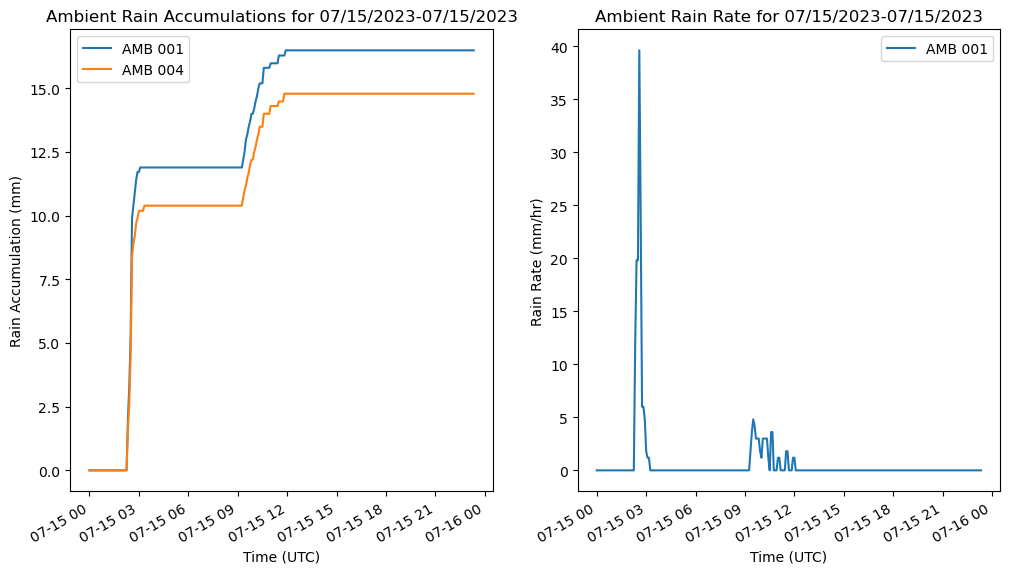

In [6]:
#create variables, counts the tips of the ambients
ds_amb_001 = ds_amb_001.assign(dailyrainmm = ds_amb_001.dailyrainin*25.4)
ds_amb_001['dailyrainmm'].attrs['units'] = 'mm'

ds_amb_004 = ds_amb_004.assign(dailyrainmm = ds_amb_004.dailyrainin*25.4)
ds_amb_004['dailyrainmm'].attrs['units'] = 'mm'


rain_001 = ds_amb_001.assign(tips=ds_amb_001['dailyrainmm'].diff('time'))
rain_001['tips'].attrs['units'] = 'mm'

rain_004 = ds_amb_004.assign(tips=ds_amb_004['dailyrainmm'].diff('time'))
rain_004['tips'].attrs['units'] = 'mm'

#remove the negative values from finding the difference above
rain_001['tips'] = rain_001.tips.where(rain_001.tips >= 0.0, drop=True)
rain_004['tips'] = rain_004.tips.where(rain_004.tips >= 0.0, drop=True)

#create the rain rate variables
rain_rate_001 = ds_amb_001.hourlyrainin*25.4
rain_rate_004 = ds_amb_004.hourlyrainin*25.4


#figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

#the plot info
rain_001.tips.cumsum().plot(ax=ax1, label='AMB 001')
rain_004.tips.cumsum().plot(ax=ax1, label='AMB 004')
ax1.set_title((('Ambient Rain Accumulations for ' +
            str(ds_amb_001.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_amb_001.time[-1].dt.strftime('%m/%d/%Y').data))
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Rain Accumulation (mm)')
ax1.legend()


#Plotting intensity data
rain_rate_001.plot(ax=ax2, label='AMB 001')
#rain_rate_004.plot(ax=ax2, label='AMB 004')

ax2.set_title((('Ambient Rain Rate for ' +
            str(ds_amb_001.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_amb_001.time[-1].dt.strftime('%m/%d/%Y').data))
ax2.set_xlabel('Time (UTC)')
ax2.set_ylabel('Rain Rate (mm/hr)')
ax2.legend()

# Show the plot
plt.show()

### Plot NovaLynx 12 in Tipping Bucket Rain Guage

Text(0.5, 0, 'Time (UTC)')

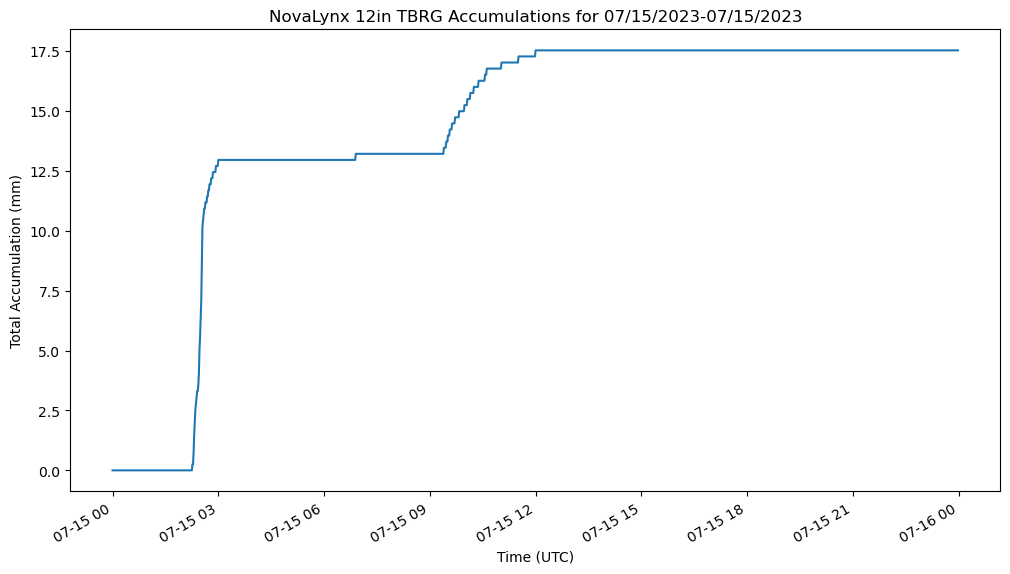

In [7]:
#define the variables
rain_accum_12 = np.cumsum(ds_org_apg.tb_rain_mm_12in_Tot - ds_org_apg.tb_rain_mm_12in_Tot[0])

#plot
rain_accum_12.plot(figsize=(12, 6))
plt.title((('NovaLynx 12in TBRG Accumulations for ' +
            str(ds_org_apg.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_org_apg.time[-1].dt.strftime('%m/%d/%Y').data))
plt.ylabel('Total Accumulation (mm)')
plt.xlabel('Time (UTC)')

### Plot MET ONE 8in Tipping Bucket Rain Gauge

Text(0.5, 0, 'Time (UTC)')

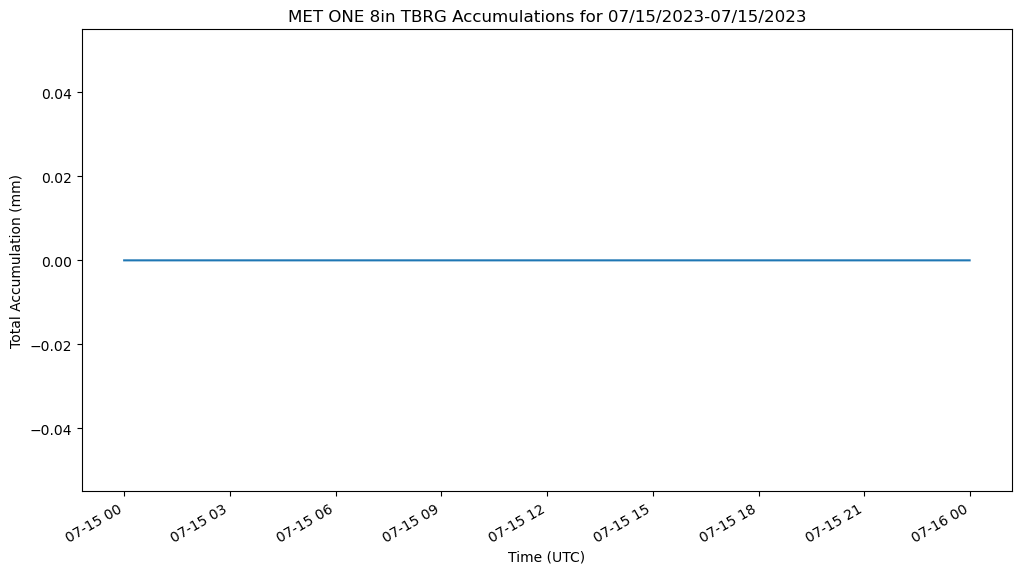

In [8]:
#define the variables
rain_accum_8 = np.cumsum(ds_org_apg.tb_rain_mm_8in_Tot - ds_org_apg.tb_rain_mm_8in_Tot[0])

#plot
rain_accum_8.plot(figsize=(12, 6))
plt.title((('MET ONE 8in TBRG Accumulations for ' +
            str(ds_org_apg.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_org_apg.time[-1].dt.strftime('%m/%d/%Y').data))
plt.ylabel('Total Accumulation (mm)')
plt.xlabel('Time (UTC)')

### Plot the Tower MET ONE 8in Tipping Bucket Rain Gauge

Text(0.5, 0, 'Time (UTC)')

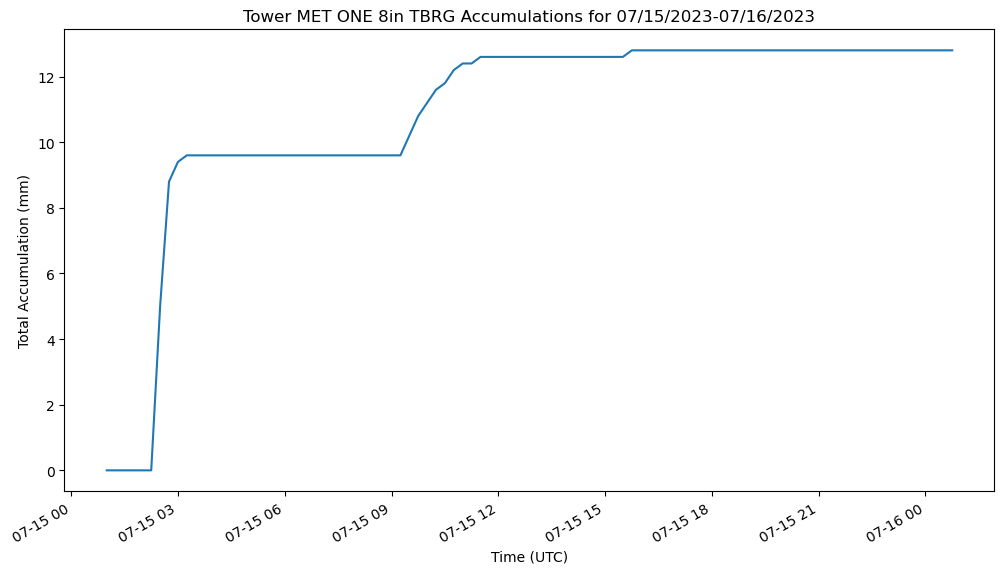

In [9]:
#define the variables
accum_tower = ((ds_tower.precip)).cumsum()

#plot
accum_tower.plot(figsize=(12, 6))
plt.title((('Tower MET ONE 8in TBRG Accumulations for ' +
            str(ds_tower.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_tower.time[-1].dt.strftime('%m/%d/%Y').data))
plt.ylabel('Total Accumulation (mm)')
plt.xlabel('Time (UTC)')

# Create Plots to Compare Rain Totals Between All of the Instruments

## Event Rain Accumulation Plot

First find the average values for the cocorahs gauges, we will use it as the baseline "correct" value that we are comparing everything else to

In [10]:
#Find the average of the CoCoRaHS Gauges and print it
sum_CRH=(0.62)+(0.6)+(0.64)
avg_CRH=((sum_CRH)/3)*25.4
print('AVG CRH:', avg_CRH)

AVG CRH: 15.748


Add the weighted bucket rain gauge total (also from a seperate spreadsheet)

In [11]:
#Add the values for weighted bucket rain gauge
wbrg = 17.145

Now make the actual plot with all the data that we have

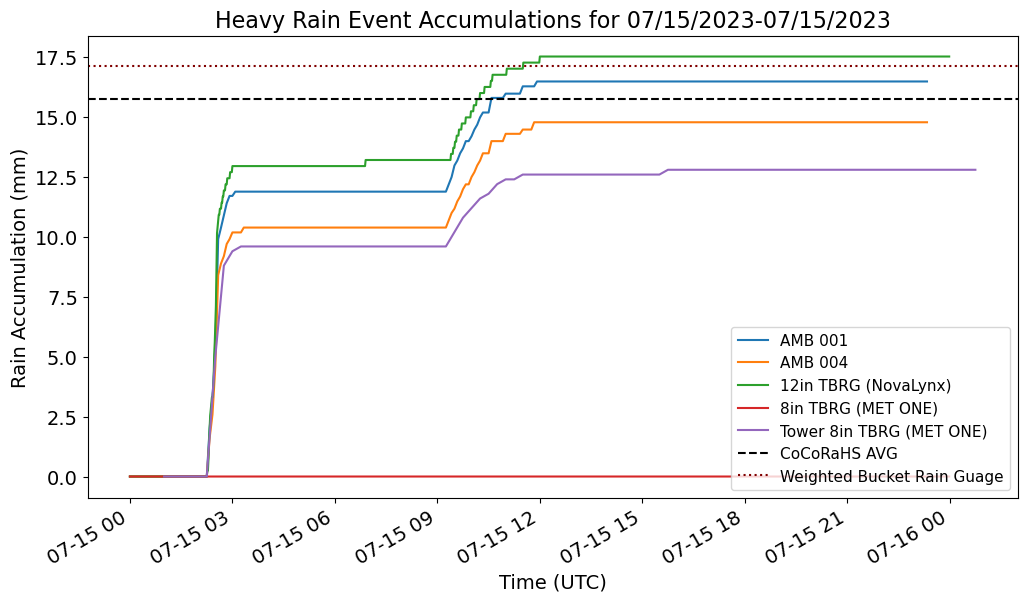

In [12]:
#figure with subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

#the plot info
rain_001.tips.cumsum().plot(ax=ax1, label='AMB 001')
rain_004.tips.cumsum().plot(ax=ax1, label='AMB 004')
rain_accum_12.plot(ax=ax1, label='12in TBRG (NovaLynx)')
rain_accum_8.plot(ax=ax1, label='8in TBRG (MET ONE) ')
accum_tower.plot(ax=ax1, label='Tower 8in TBRG (MET ONE)')
plt.axhline(y = avg_CRH, color = 'k', linestyle='--', label = 'CoCoRaHS AVG')
plt.axhline(y = wbrg, color = 'maroon', linestyle=':', label = 'Weighted Bucket Rain Guage')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

ax1.set_title((('Heavy Rain Event Accumulations for ' +
            str(ds_amb_001.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_amb_001.time[-1].dt.strftime('%m/%d/%Y').data), fontsize = 16)
ax1.set_xlabel('Time (UTC)', fontsize = 14)
ax1.set_ylabel('Rain Accumulation (mm)', fontsize = 14)
ax1.legend(loc='lower right', fontsize = 11 )

# Show the two plots 
plt.show()

## Plot for Rain Total per Gauge

First we need to define the percent error for each instrument to be used for the percent error bars

In [13]:
#define the percent error for each instrument to be used below
error_001 = 4.0
error_004 = 4.0
error_novalynx = 1.0
error_metone_8 = 1.0 #use 1.0 for heavy rain (25.4-76.2 mm/hr), and 0.5 for light (<12.7 mm/hr)
error_metone_tower =  1.0 
error_wbrg = 0.5
error_metone_12 = 1.0 #use 2.0 for heavy rain (< 76.2 mm/hr), and 0.5 for light (<12.7 mm/hr)
error_crh = 4.0

Now create the plot

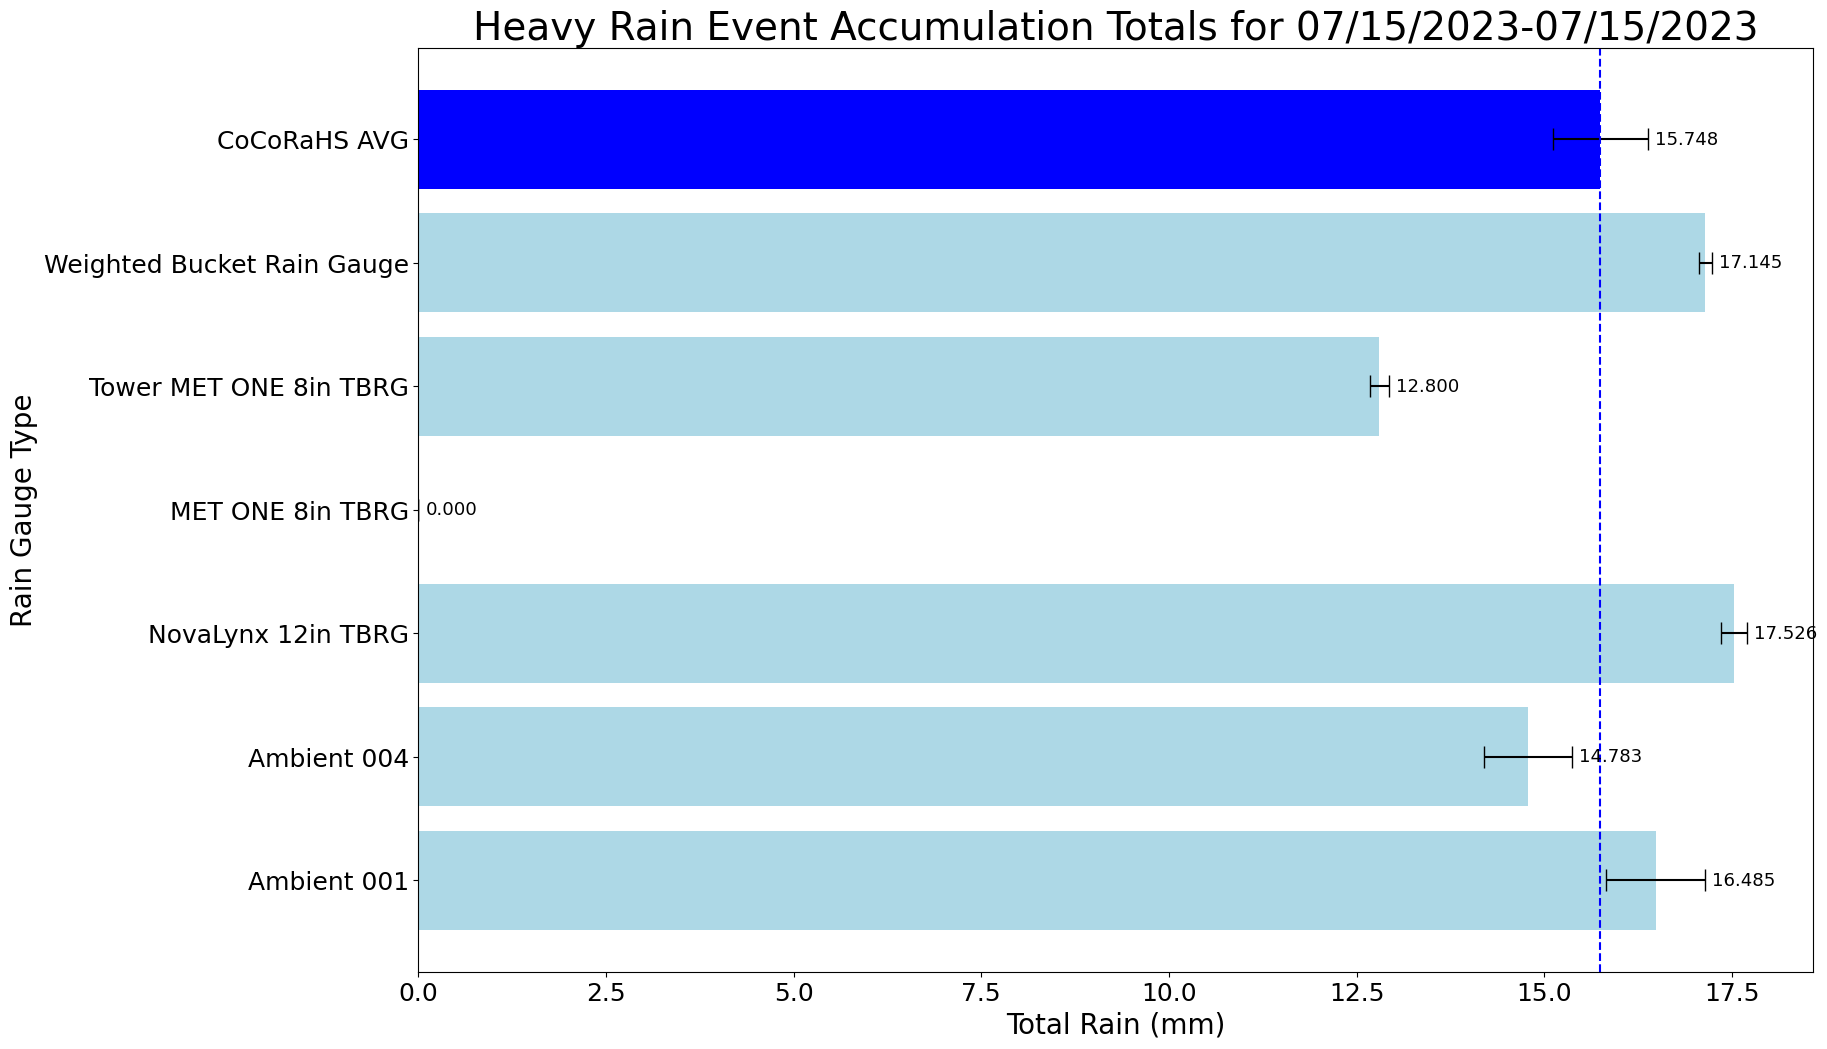

In [14]:
#define the data for the Main Gauges
data = {'Ambient 001':rain_001.tips.cumsum().max(), 'Ambient 004':rain_004.tips.cumsum().max(),
        'NovaLynx 12in TBRG':rain_accum_12.values.max(), 'MET ONE 8in TBRG': rain_accum_8.values.max(),
        'Tower MET ONE 8in TBRG': accum_tower.values.max(), 'Weighted Bucket Rain Gauge': wbrg }

# Define the error percentages for main guages
error_percentages = [error_001, error_004, error_novalynx, error_metone_8,
                     error_metone_tower, error_wbrg]

#set up plot
rain_gauges = list(data.keys())
precip_totals = list(data.values())
fig = plt.figure(figsize = (18, 12))
ax=fig.add_subplot(111)

# Calculate the error bars for main gauges
error_bars = np.array(precip_totals) * np.array(error_percentages) / 100

#calculate thee error bars for the cocorahs 
error_bars_crh = avg_CRH * error_crh / 100


# Plot all of the Main Gauges with error bars
all_rg_bar = ax.barh(rain_gauges, precip_totals, xerr=error_bars, color='lightblue', capsize=8)
ax.bar_label(all_rg_bar, fmt='%.3f', padding = 5, fontsize = 13)


#Adding and plotting the CoCoRaHS data
crh_bar=ax.barh(['CoCoRaHS AVG'], [avg_CRH], xerr = error_bars_crh, color='b', capsize=8)
ax.bar_label(crh_bar, fmt='%.3f', padding = 5, fontsize = 13)


#Add a line to be able to more clearly visualize the "true" value of the total event rainfall
plt.axvline(x = avg_CRH, color = 'b', linestyle='--')


#plot the graph

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylabel("Rain Gauge Type", fontsize=20)
plt.xlabel("Total Rain (mm)", fontsize=20)
plt.title((('Heavy Rain Event Accumulation Totals for ' +
            str(ds_amb_001.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_amb_001.time[-1].dt.strftime('%m/%d/%Y').data), fontsize = 28)
plt.show()

## Percent Error for Each Rain Gauge

Find the percent error for each of the rain gauges and print the results

In [15]:
amb_001_diff = abs(((rain_001.tips.cumsum().max() - avg_CRH)/avg_CRH)*100)
amb_004_diff = abs(((rain_004.tips.cumsum().max() - avg_CRH)/avg_CRH)*100)
tbrg_12_diff = abs(((rain_accum_12.values.max() - avg_CRH)/avg_CRH)*100)
tbrg_8_diff = abs(((rain_accum_8.values.max() - avg_CRH)/avg_CRH)*100)
tbrg_tower_diff =abs(((accum_tower.values.max() - avg_CRH)/avg_CRH)*100)
wbrg_diff = abs (((wbrg - avg_CRH)/avg_CRH)*100)

print('amb-001 percent error:   ', amb_001_diff, '%')
print('amb-004 percent error:   ', amb_004_diff, '%')
print('12in tbrg percent error: ', tbrg_12_diff, '%')
print('8in tbrg percent error:  ', tbrg_8_diff, '%')
print('tower tbrg percent error:', tbrg_tower_diff, '%')
print('Weighted bucket percent error:', wbrg_diff, '%')

amb-001 percent error:    <xarray.DataArray 'tips' ()>
array(4.67741935) %
amb-004 percent error:    <xarray.DataArray 'tips' ()>
array(6.12903226) %
12in tbrg percent error:  11.290322580645165 %
8in tbrg percent error:   100.0 %
tower tbrg percent error: 18.719837439674894 %
Weighted bucket percent error: 8.870967741935486 %


Create a plot with the percent errors 

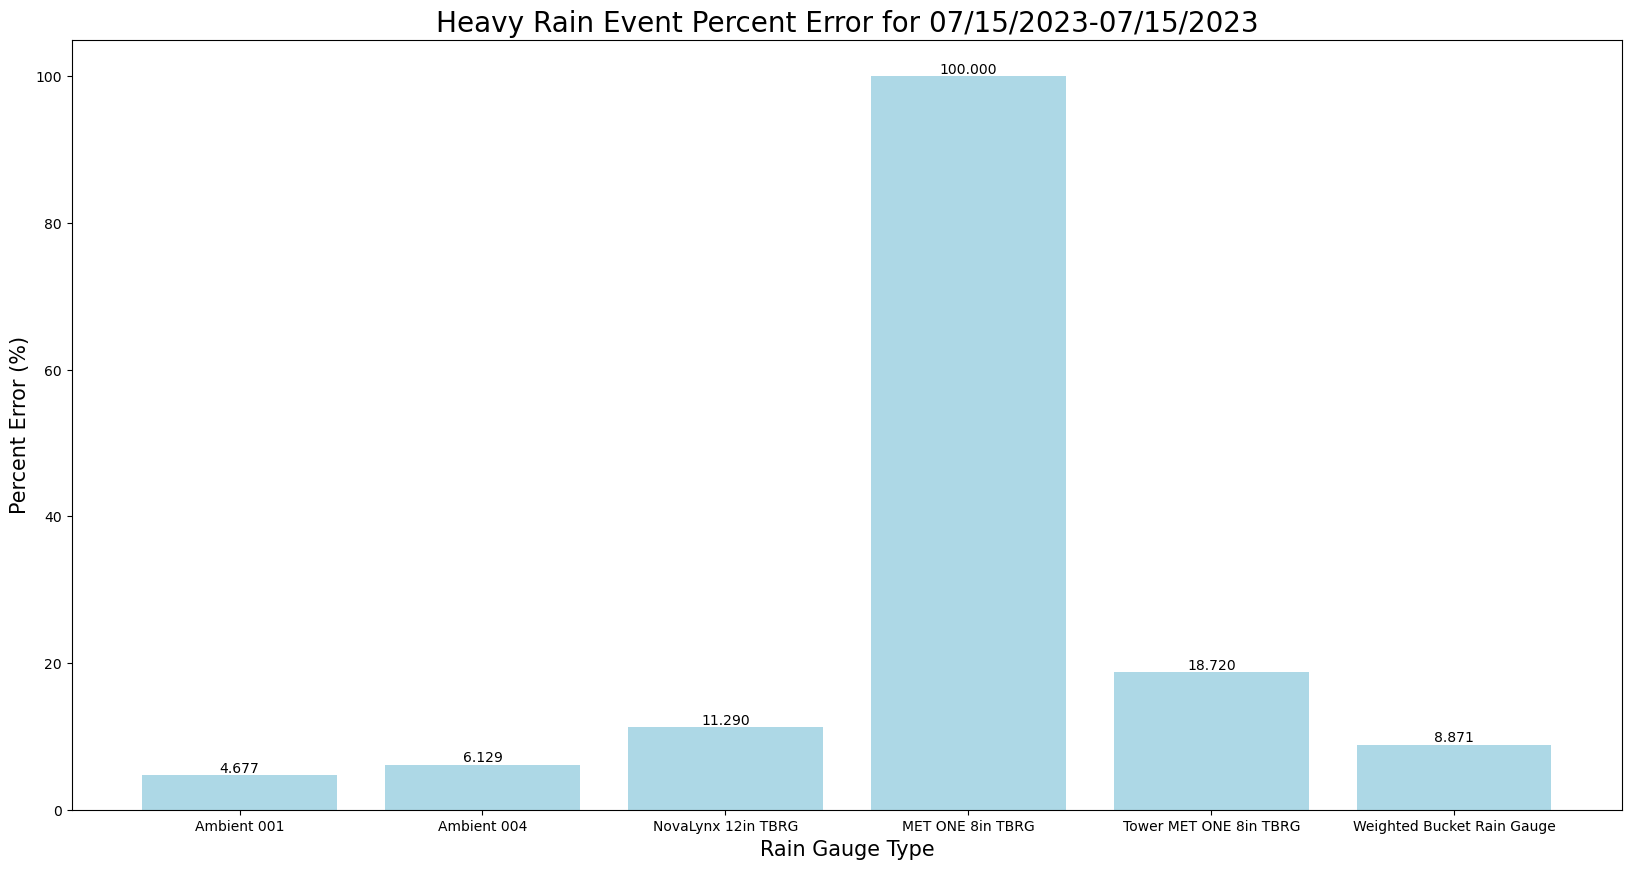

In [16]:
#Plot all of the Main Gauges
data = {'Ambient 001':amb_001_diff, 'Ambient 004':amb_004_diff,'NovaLynx 12in TBRG':tbrg_12_diff, 'MET ONE 8in TBRG': tbrg_8_diff, 
        'Tower MET ONE 8in TBRG': tbrg_tower_diff, 'Weighted Bucket Rain Gauge': wbrg_diff} #removed fd70 since we don't have data for 14th


rain_gauges = list(data.keys())
precip_totals = list(data.values())
fig = plt.figure(figsize = (20, 10))
ax=fig.add_subplot(111)

all_rg_bar=plt.bar(rain_gauges, precip_totals, color ='lightblue')
ax.bar_label(all_rg_bar, fmt='%.3f')

#plot the graph
plt.xlabel("Rain Gauge Type", fontsize=15)
plt.ylabel("Percent Error (%)", fontsize=15)
plt.title((('Heavy Rain Event Percent Error for ' +
            str(ds_amb_001.time[0].dt.strftime('%m/%d/%Y').data)))+'-'+
            str(ds_amb_001.time[-1].dt.strftime('%m/%d/%Y').data), fontsize = 20)
plt.show()